# Parse Data

In [1]:
CUTOFF = 10

In [2]:
PATH_THUIR2 = 'data/THUIR2/search_logs.xml'

try:
    import xml.etree.cElementTree as ET
except ImportError:
    import xml.etree.ElementTree as ET
import json

def xml_to_dict(element):
    node = {}

    text = getattr(element, 'text', None)
    if text is not None:
        text = text.strip()
        # no attributes or children
        if text and not element.attrib and len(element) == 0:  
            return text

    node.update(element.attrib)

    for child in element:
        child_data = xml_to_dict(child)

        if child.tag not in node:
            node[child.tag] = child_data
        else:
            if type(node[child.tag]) is list:
                node[child.tag].append(child_data)
            else:
                node[child.tag] = [node[child.tag], child_data]

    return node

def parse_xml_to_json(xml_file_path, json_file_path):
    # 解析 XML 文件
    myParser = ET.XMLParser(encoding="utf-8")
    tree = ET.parse(xml_file_path, parser=myParser)
    root = tree.getroot()

    # 转换为 JSON
    data_dict = xml_to_dict(root)
    with open(json_file_path, 'w', encoding='utf-8') as json_file:
        json.dump(data_dict, json_file, ensure_ascii=False, indent=4)
    
    return data_dict
    

thuir2_parsed = parse_xml_to_json(PATH_THUIR2, 'data/THUIR2_parsed.json')
thuir2_ss = thuir2_parsed['session']

In [3]:
# sample data
#print(thuir2_ss[0])

# Utility Functions to Get Document Usefulness & Relevance

In [4]:
import csv

PATH_USEFULNESS = 'data/THUIR2/usefulness_annotation.tsv'
PATH_RELEVANCE = 'data/THUIR2/relevance_annotation.tsv'
# This dict will hold the usefulness data
# First key: userid
# Second key: docno
usefulness_data = {}

# Read the CSV file
with open(PATH_USEFULNESS, 'r') as file:
    reader = csv.reader(file, delimiter='\t')
    next(reader)  # Skip the header row
    for row in reader:
        # Get the userid, docno, and usefulness from each row
        userid = row[1]
        docno = row[4]
        usefulness = row[8]

        # Add the data to the dict
        if userid not in usefulness_data:
            usefulness_data[userid] = {}
        usefulness_data[userid][docno] = int(usefulness)

# This dict will hold the relevance data
relevance_data = {}

# Read the CSV file
with open(PATH_RELEVANCE, 'r') as file:
    reader = csv.reader(file, delimiter='\t')
    next(reader)  # Skip the header row
    for row in reader:
        # Get the docno and relevance from each row
        docno = row[2]
        relevance = row[3]

        # Add the data to the dict
        relevance_data[docno] = int(relevance)
        

In [5]:
# Print the usefulness data
# This is actually no use
#print(dict(list(usefulness_data.items())[:5]))

In [66]:
# Print the relevance data
print(dict(list(relevance_data.items())[:5]))

# Values
values = np.array(list(relevance_data.values()))

# Calculate mean and standard deviation
mean_value = np.mean(values)
std_dev_value = np.std(values)

mean_value, std_dev_value

{'199': 1, '18606': 1, '9681': 2, '19787': 2, '20589': 4}


(2.557487922705314, 0.9462168771896936)

# Utility Functions to Compute Sentence Similarity

In [7]:
from Levenshtein import distance, ratio
import jieba
from collections import Counter
from math import sqrt

SW_PATH = 'utils/stop_words.txt'
SW_LIST = [k.strip() for k in open(SW_PATH, encoding='utf8').readlines() if k.strip() != '']

# Get Stopword List
def get_tl_no_sw(input_sentence):
    token_list = jieba.cut(input_sentence)
    return list(filter(lambda x: not(x == ' ' or (len(x) == 1 and x in SW_LIST)), token_list))


In [8]:
# Solution 1
# Levenshtein normalized similarity

def get_lev_sim(list1, list2):
    return ratio(''.join(sl_no_sw_1), ''.join(sl_no_sw_2))

# Solution 2
# Cosine Similarity

def get_cos_sim(list1, list2):
    # Step 1: Create a vocabulary
    vocab = set(list1) | set(list2)
    
    # Step 2: Create word frequency vectors
    vec1 = Counter(list1)
    vec2 = Counter(list2)
    
    # Step 3: Calculate cosine similarity
    intersection = set(vec1.keys()) & set(vec2.keys())
    numerator = sum([vec1[x] * vec2[x] for x in intersection])

    sum1 = sum([vec1[x]**2 for x in vec1.keys()])
    sum2 = sum([vec2[x]**2 for x in vec2.keys()])
    denominator = sqrt(sum1) * sqrt(sum2)

    if not denominator:
        return 0.0
    else:
        return float(numerator) / denominator


In [9]:
# sample data
sentence1 = '破冰游戏又称融冰游戏，是打破人际交往间怀疑、猜忌，就象打破严冬厚厚的冰层。这个破冰拓展游戏帮助人们变得乐于交往和相互学习，打破陌生人之间的隔膜，消除同事间的积...'
sentence2 = '破冰游戏大全提供各种团队破冰游戏和小组破冰游戏，打破人际交往间怀疑、猜忌、疏远的篱樊，帮助人们放松并变得乐于交往和相互学习。'
sl_no_sw_1 = get_tl_no_sw(sentence1)
sl_no_sw_2 = get_tl_no_sw(sentence2)

print("Lev Sim: %.3f" % get_lev_sim(sl_no_sw_1, sl_no_sw_2))
print("Cos Sim: %.3f" % get_cos_sim(sl_no_sw_1, sl_no_sw_2))


Building prefix dict from the default dictionary ...
Dumping model to file cache /var/folders/7k/8q9xq4596mb6rkfh3c6gknc00000gn/T/jieba.cache
Loading model cost 0.706 seconds.
Prefix dict has been built successfully.


Lev Sim: 0.512
Cos Sim: 0.681


In [10]:
from tqdm import tqdm

# Define a placeholder get_sim function for demonstration purpose
def get_sim(tl_1, tl_2):
    return get_cos_sim(tl_1, tl_2)

In [11]:
# Create a dictionary to hold each document's title, snippet grouped by topic
documents_by_topic = {}

for session in tqdm(thuir2_ss, desc="Processing records"):
    topic = session["topic"]["num"]
    interactions = session["interaction"]
    
    # Helper function to process results and store document info by topic
    def process_results_by_topic(results, topic):
        for doc in results:
            doc_id = doc["id"]
            doc_info = doc["title"] + " " + str(doc["snippet"])
            doc_token_list = get_tl_no_sw(doc_info)
            if topic not in documents_by_topic:
                documents_by_topic[topic] = {}
            documents_by_topic[topic][doc_id] = doc_info

    # Check if interactions is a list or a dict
    if isinstance(interactions, list):
        for interaction in interactions:
            # Check if "results" is not empty
            if interaction.get("results"):
                results = interaction["results"]["result"]
                process_results_by_topic(results, topic)
    elif isinstance(interactions, dict):
        # Check if "results" is not empty
        if interactions.get("results"):
            results = interactions["results"]["result"]
            process_results_by_topic(results, topic)

Processing records: 100%|█████████████████████| 225/225 [00:05<00:00, 38.24it/s]


In [12]:
# VERY time consuming
def get_similarity_pair():
    similarity_scores = {}
    # For each topic, compare each document with every other document in the same topic
    for topic, documents in documents_by_topic.items():
        print("Currently processing: " + topic)
        for doc_id1 in tqdm(documents, desc="Processing topics"):
            for doc_id2 in documents:
                # Ensure doc_id1 is smaller than doc_id2
                if doc_id1 >= doc_id2:
                    continue
                # Calculate similarity
                similarity = get_sim(documents[doc_id1], documents[doc_id2])
                # Store in the dictionary
                if doc_id1 not in similarity_scores:
                    similarity_scores[doc_id1] = {}
                similarity_scores[doc_id1][doc_id2] = similarity

    # Save the similarity scores to a JSON file
    OUTPUT_FILE = "output/similarity_scores.json"
    with open(OUTPUT_FILE, 'w') as f:
        json.dump(similarity_scores, f)


In [13]:
#get_similarity_pair()

# Read json file directly
with open('output/similarity_scores.json', 'r', encoding='utf-8') as file:
    similarity_scores = json.load(file)


In [14]:
similarity_pair_list = [(docno1, docno2, score) 
               for docno1, inner_dict in similarity_scores.items() 
               for docno2, score in inner_dict.items()]

print(similarity_pair_list[:20])

[('1', '2', 0.45961940777125593), ('1', '3', 0.42759637577789017), ('1', '4', 0.51428352870058), ('1', '5', 0.41316712200642336), ('1', '6', 0.5342072242964954), ('1', '7', 0.37119616932281163), ('1', '8', 0.5458670563274626), ('1', '9', 0.2405626121623441), ('1', '10', 0.4283836420813328), ('1', '14182', 0.3447271465312176), ('1', '14183', 0.2590095632952705), ('1', '14184', 0.3118047822311618), ('1', '14185', 0.15523010514126656), ('1', '14186', 0.1666666666666667), ('1', '14187', 0.2403809869102058), ('1', '14188', 0.3889733106610521), ('1', '14189', 0.11612216904860295), ('1', '14190', 0.10067340828210367), ('1', '14191', 0.09723055853282468), ('1', '16145', 0.3286878675669583)]


In [15]:
import numpy as np

# Extract the similarity scores
similarity_list = [x[2] for x in similarity_pair_list]

# Function to calculate the xth percentile
def calculate_percentile(scores, x):
    return np.percentile(scores, x)

# Calculate percentiles for 10, 20, 25, 50, 75, 90
percentiles = [80, 90, 95, 99, 99.5, 99.9]
percentile_values = {x: calculate_percentile(similarity_list, x) for x in percentiles}

percentile_values

{80: 0.3200378765462651,
 90: 0.39717310945384937,
 95: 0.4673017274310339,
 99: 0.6260429022366066,
 99.5: 0.7085457904689538,
 99.9: 0.9999999999999999}

# Find Potential Decoy Pairs

In [16]:
#SIM_HERESHOLD_UNIFY = 0.75
import math

In [17]:
# 假设的相似度阈值
SIM_THRESHOLD_DECOY_MIN = calculate_percentile(similarity_list, 99) 
#SIM_THRESHOLD_DECOY_MIN = 0.65
SIM_THRESHOLD_DECOY_MAX = 0.95
decoy_pair = []  # 初始化 decoy_pair 字典

# 定义一个函数来处理交互，这样我们可以在交互是列表或字典时重复使用它
def find_decoy_pair(interaction, session_num):
    if 'result' not in interaction['results']:
        #print(interaction['results'])
        return
    # 提取 docno 和 rank
    docnos = [result['id'] for result in interaction['results']['result']]
    ranks = [result['rank'] for result in interaction['results']['result']]
    # 提取点击记录，如果存在的话
    #clicked_items = []
    #if "clicked" in interaction and "click" in interaction["clicked"]:
    #    clicked_items = [item["docno"] for item in interaction["clicked"]["click"] if isinstance(item, dict)]
    
    # 只考虑结果的前K个文档
    for i in range(min(CUTOFF, len(docnos))):
        for j in range(i+1, min(CUTOFF, len(docnos))):
            docno1, rank1 = docnos[i], ranks[i]
            docno2, rank2 = docnos[j], ranks[j]
            if docno1 > docno2:  # 确保 docno1 < docno2
                docno1, docno2 = docno2, docno1
                rank1, rank2 = rank2, rank1
            # 检查条件
            rel_doc1 = relevance_data[docno1] if docno1 in relevance_data else 0
            rel_doc2 = relevance_data[docno2] if docno2 in relevance_data else 0
            
            if similarity_scores[docno1][docno2] >= SIM_THRESHOLD_DECOY_MIN and similarity_scores[docno1][docno2] <= SIM_THRESHOLD_DECOY_MAX and abs(i-j)<=5:
                if rel_doc1 - rel_doc2 >= 2:
                #if docno1 in clicked_items and docno2 not in clicked_items:
                    decoy_pair.append({'session_num': session_num, 'interaction_num': interaction['num'], 
                                       'docno_target': docno1, 'rank_target': rank1, 
                                       'docno_decoy': docno2, 'rank_decoy': rank2})
                elif rel_doc2 - rel_doc1 >= 2:
                #elif docno2 in clicked_items and docno1 not in clicked_items:
                    decoy_pair.append({'session_num': session_num, 'interaction_num': interaction['num'], 
                                       'docno_target': docno2, 'rank_target': rank2, 
                                       'docno_decoy': docno1, 'rank_decoy': rank1})


# 遍历每条记录
for record in tqdm(thuir2_ss, desc="Processing sessions", unit="session"):
    session_num = record['num']  # 提取 session num
    # 遍历每次交互
    interactions = record['interaction']
    if isinstance(interactions, list):  # 如果交互是一个列表
        for interaction in interactions:
            find_decoy_pair(interaction, session_num)
    elif isinstance(interactions, dict):  # 如果交互是一个字典
        find_decoy_pair(interactions, session_num)
        
        
print(len(decoy_pair))
print(decoy_pair[:10])

Processing sessions: 100%|█████████████| 225/225 [00:00<00:00, 5468.20session/s]

982
[{'session_num': '1', 'interaction_num': '1', 'docno_target': '2', 'rank_target': '1', 'docno_decoy': '6', 'rank_decoy': '5'}, {'session_num': '1', 'interaction_num': '1', 'docno_target': '3', 'rank_target': '2', 'docno_decoy': '6', 'rank_decoy': '5'}, {'session_num': '1', 'interaction_num': '1', 'docno_target': '4', 'rank_target': '3', 'docno_decoy': '6', 'rank_decoy': '5'}, {'session_num': '1', 'interaction_num': '1', 'docno_target': '8', 'rank_target': '7', 'docno_decoy': '6', 'rank_decoy': '5'}, {'session_num': '1', 'interaction_num': '3', 'docno_target': '16145', 'rank_target': '0', 'docno_decoy': '16146', 'rank_decoy': '1'}, {'session_num': '1', 'interaction_num': '3', 'docno_target': '16148', 'rank_target': '3', 'docno_decoy': '16146', 'rank_decoy': '1'}, {'session_num': '3', 'interaction_num': '1', 'docno_target': '1638', 'rank_target': '9', 'docno_decoy': '1634', 'rank_decoy': '5'}, {'session_num': '3', 'interaction_num': '3', 'docno_target': '1638', 'rank_target': '9', 'd

In [18]:
decoy_index = [item['docno_target'] for item in decoy_pair]
print("Decoy Pairs Count: %d"%len(decoy_index))
print("Count of Documents that have at least one decoy: %d"%len(set(decoy_index)))
#print(decoy_index[:5])

Decoy Pairs Count: 982
Count of Documents that have at least one decoy: 318


# Find Control Documents

In [19]:
# Assuming a threshold for the sake of demonstration
SIM_THRESHOLD_CONTROL = calculate_percentile(similarity_list, 99.5)  
print(SIM_THRESHOLD_CONTROL)
target_doc_list = []
control_doc_list = []

# Processing the data as per given conditions
for docno1, docno2, similarity_score in similarity_pair_list:
    if similarity_score > SIM_THRESHOLD_CONTROL:
        # 检查条件
        rel_doc1 = relevance_data[docno1] if docno1 in relevance_data else 0
        rel_doc2 = relevance_data[docno2] if docno2 in relevance_data else 0
        if abs(rel_doc1 - rel_doc2 <= 0):
            if (docno1 in decoy_index and docno2 not in decoy_index):
                target_doc_list.append(docno1)
                control_doc_list.append(docno2)
            elif (docno2 in decoy_index and docno1 not in decoy_index):
                target_doc_list.append(docno2)
                control_doc_list.append(docno1)

target_doc_set = set(target_doc_list)
print("Count of Target Documents that have at least one Control Document: %d"% len(target_doc_set))
control_doc_set = set(control_doc_list)
print("Count of Control Documents: %d" % len(control_doc_set))

0.7085457904689538
Count of Target Documents that have at least one Control Document: 242
Count of Control Documents: 713


In [20]:
decoy_target_record = []
decoy_decoy_record = []
for item in decoy_pair:
    if item['docno_target'] in target_doc_set:
        target_id = item['session_num'] + '_' + item['interaction_num'] + '_' + item['docno_target']
        decoy_id =  item['session_num'] + '_' + item['interaction_num'] + '_' + item['docno_decoy']
        decoy_target_record.append(target_id)
        decoy_decoy_record.append(decoy_id)
    
decoy_target_record = set(decoy_target_record)
decoy_decoy_record = set(decoy_decoy_record)

print("Records of decoy target documents, by impression : %d"%len(decoy_target_record))
#print(len(decoy_decoy_record))

Records of decoy target documents, by impression : 721


# Compare User Feedback

In [21]:
def process_user_feedback(results, decoy_target_record, session_num, interaction_num, user_id, topic_id):
    """
    Process the results to extract required information.
    """
    interactions_list = []
    
    for item in results:
        record_id = session_num + '_' + interaction_num + '_' + item['id']
        # Check if record_id is in decoy_target_record
        # And whether the document has at least one control document
        if record_id in decoy_target_record and int(item['rank']) < CUTOFF:
            if "clicked" in interaction and "click" in interaction["clicked"]:
                clicked_items = interaction["clicked"]["click"]
                clicked = False
                endtime = -1
                starttime = -1
                usefulness = 0
                for click_item in clicked_items:
                    if isinstance(click_item, dict) and item['id'] == click_item["docno"]:
                        clicked = True
                        endtime = float(click_item['endtime'])
                        starttime = float(click_item['starttime'])
                        usefulness = float(click_item["annotation"]['score'])
                        break
            else:
                clicked = False
                endtime = -1
                starttime = -1
                usefulness = 0

            if clicked:
                interactions_list.append({'docno': item['id'], 'task_id': topic_id, 'student_id': user_id, 
                                          'rank':  int(item["rank"]), 'click': True, 'last_time':(endtime-starttime), 
                                          'usefulness': usefulness, 'relevance': relevance_data.get(item['id'], 0)})
            else:
                interactions_list.append({'docno': item['id'], 'task_id': topic_id, 'student_id': user_id, 
                                          'rank': int(item["rank"]), 'click': False, 'last_time': 0, 
                                          'usefulness': 0, 'relevance': relevance_data.get(item['id'], 0)})
                
    return interactions_list


target_doc_interaction = []

for session in thuir2_ss:
    session_num = session["num"]
    interactions = session["interaction"]
    student_id = session["userid"]
    topic_id = session['topic']['num']
    
    # Check if interactions is a list or a dict
    if isinstance(interactions, list):
        for interaction in interactions:
            interaction_num = interaction["num"]
            if interaction.get("results"):
                results = interaction["results"]["result"]
                interactions_list = process_user_feedback(results, decoy_target_record, session_num, interaction_num, student_id, topic_id)
                target_doc_interaction.extend(interactions_list)
    
    elif isinstance(interactions, dict):
        interaction_num = interactions["num"]
        if interaction.get("results"):
            results = interactions["results"]["result"]
            interactions_list = process_user_feedback(results, decoy_target_record, session_num, interaction_num, student_id, topic_id)
            target_doc_interaction.extend(interactions_list)

print(len(target_doc_interaction))

711


In [22]:
def process_control_docs(results, control_doc_set):
    """
    Process the results to extract required information for control docs.
    """
    interactions_list = []
    
    for item in results:
        # Check if the item's id is in control_doc_set
        if item['id'] in control_doc_set and int(item['rank']) < CUTOFF:
            if "clicked" in interaction and "click" in interaction["clicked"]:
                clicked_items = interaction["clicked"]["click"]
                clicked = False
                endtime = -1
                starttime = -1
                usefulness = 0
                for click_item in clicked_items:
                    if isinstance(click_item, dict) and item['id'] == click_item["docno"]:
                        clicked = True
                        endtime = float(click_item['endtime'])
                        starttime = float(click_item['starttime'])
                        usefulness = float(click_item["annotation"]['score'])
                        break
            else:
                clicked = False
                endtime = -1
                starttime = -1
                usefulness = 0

            if clicked:
                interactions_list.append({'docno': item['id'], 'task_id': topic_id, 'student_id': user_id, 
                                          'rank': int(item["rank"]), 'click': True, 'last_time': (endtime-starttime), 
                                          'usefulness': usefulness,  'relevance': relevance_data.get(item['id'], 0)})
            else:
                interactions_list.append({'docno': item['id'], 'task_id': topic_id, 'student_id': user_id, 
                                          'rank': int(item["rank"]), 'click': False, 'last_time': 0, 
                                          'usefulness': 0, 'relevance': relevance_data.get(item['id'], 0)})
                
    return interactions_list

# Initialize the list for control doc interactions
control_doc_interaction = []

for session in thuir2_ss:
    interactions = session["interaction"]
    user_id = session["userid"]
    topic_id = session['topic']['num']
    # Check if interactions is a list or a dict
    if isinstance(interactions, list):
        for interaction in interactions:
            if interaction.get("results"):
                results = interaction["results"]["result"]
                interactions_list = process_control_docs(results, control_doc_set)
                control_doc_interaction.extend(interactions_list)
    
    elif isinstance(interactions, dict):
        if interaction.get("results"):
            results = interactions["results"]["result"]
            interactions_list = process_control_docs(results, control_doc_set)
            control_doc_interaction.extend(interactions_list)
        
print(len(control_doc_interaction))

1255


In [23]:
target_doc_interaction[:3]

[{'docno': '2',
  'task_id': '1',
  'student_id': '1',
  'rank': 1,
  'click': False,
  'last_time': 0,
  'usefulness': 0,
  'relevance': 3},
 {'docno': '3',
  'task_id': '1',
  'student_id': '1',
  'rank': 2,
  'click': False,
  'last_time': 0,
  'usefulness': 0,
  'relevance': 4},
 {'docno': '4',
  'task_id': '1',
  'student_id': '1',
  'rank': 3,
  'click': False,
  'last_time': 0,
  'usefulness': 0,
  'relevance': 3}]

In [24]:
control_doc_interaction[:3]

[{'docno': '6',
  'task_id': '1',
  'student_id': '1',
  'rank': 5,
  'click': False,
  'last_time': 0,
  'usefulness': 0,
  'relevance': 0},
 {'docno': '14182',
  'task_id': '1',
  'student_id': '1',
  'rank': 0,
  'click': False,
  'last_time': 0,
  'usefulness': 0,
  'relevance': 2},
 {'docno': '14184',
  'task_id': '1',
  'student_id': '1',
  'rank': 2,
  'click': False,
  'last_time': 0,
  'usefulness': 0,
  'relevance': 2}]

In [25]:
import matplotlib.pyplot as plt

# Extract rank, click, and usefulness values
def extract_values(data):
    ranks = [item['rank']+1 for item in data]
    clicks = [item['click'] for item in data]
    usefulness = [item['usefulness'] for item in data]
    return ranks, clicks, usefulness

# Adjust the percentage calculation to account for ordering
def calculate_percentage_ordered(values, unique_values):
    total_len = len(values)
    return [values.count(val) / total_len for val in unique_values]

target_ranks, target_clicks, target_usefulness = extract_values(target_doc_interaction)
control_ranks, control_clicks, control_usefulness = extract_values(control_doc_interaction)

# Get unique values for ordering
ranks = list(set(target_ranks + control_ranks))
click_labels = ['False', 'True']
usefulness_values = list(set(target_usefulness + control_usefulness))

# Calculate ordered percentages
target_ranks_percentage = calculate_percentage_ordered(target_ranks, ranks)
control_ranks_percentage = calculate_percentage_ordered(control_ranks, ranks)

target_clicks_percentage = calculate_percentage_ordered(target_clicks, [False, True])
control_clicks_percentage = calculate_percentage_ordered(control_clicks, [False, True])

target_usefulness_percentage = calculate_percentage_ordered(target_usefulness, usefulness_values)
control_usefulness_percentage = calculate_percentage_ordered(control_usefulness, usefulness_values)

In [26]:
def plot_and_save_chart(x_values, y_values1, y_values2, title, x_label, y_label, file_name, t_color = '#3a8fb7', c_color='#ffb11b', fig_size=(6,6)):
    plt.figure(figsize=fig_size)
    width = 0.35

    # Check if x_values are strings. If so, use numerical indices.
    if isinstance(x_values[0], str):
        x_indices = range(len(x_values))
        plt.bar([x - width/2 for x in x_indices], y_values1, width, label='Target', color=t_color)
        plt.bar([x + width/2 for x in x_indices], y_values2, width, label='Control', color=c_color)
        plt.xticks(x_indices, x_values)
    else:
        plt.bar([x - width/2 for x in x_values], y_values1, width, label='Target', color=t_color)
        plt.bar([x + width/2 for x in x_values], y_values2, width, label='Control', color=c_color)

    plt.title(title, fontsize= 14)
    plt.xlabel(x_label, fontsize= 14)
    plt.ylabel(y_label, fontsize= 14)
    plt.legend(fontsize= 14)

    if isinstance(x_values[0], str):
        plt.xticks(range(len(x_values)), x_values)
    
    plt.tight_layout()
    plt.savefig(f"./output/fig/{file_name}.pdf")
    plt.show()

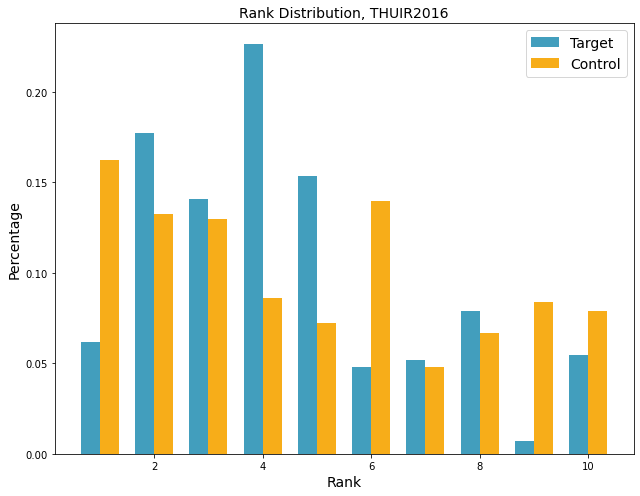

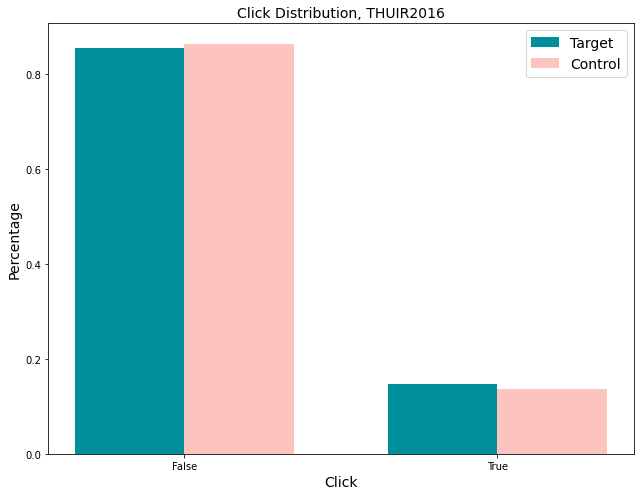

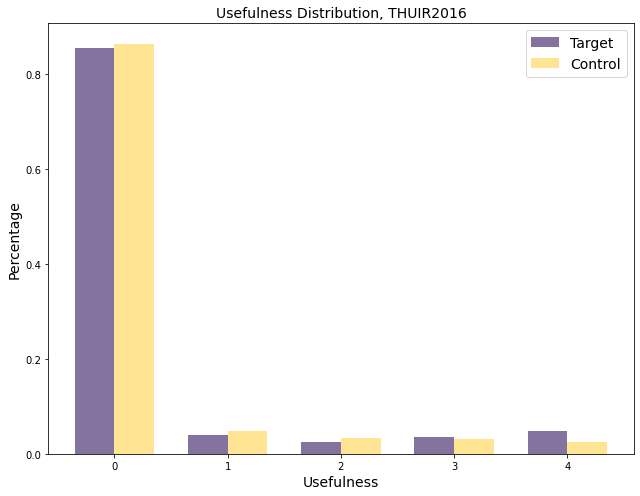

In [64]:
# Plot Rank Distribution and save as PDF
plot_and_save_chart(ranks, target_ranks_percentage, control_ranks_percentage, 
                    'Rank Distribution, THUIR2016', 'Rank', 'Percentage', 'thuir2_rank','#429EBD', '#F7AD19',(9,7))

# Plot Click Distribution and save as PDF
plot_and_save_chart(click_labels, target_clicks_percentage, control_clicks_percentage, 
                    'Click Distribution, THUIR2016', 'Click', 'Percentage', 'thuir2_click_prob','#018F9C','#FDC3BE',(9,7))

# Plot Usefulness Distribution and save as PDF
plot_and_save_chart(usefulness_values, target_usefulness_percentage, control_usefulness_percentage, 
                    'Usefulness Distribution, THUIR2016', 'Usefulness', 'Percentage', 'thuir2_usefulness', '#83739E', '#FFE494',(9,7))

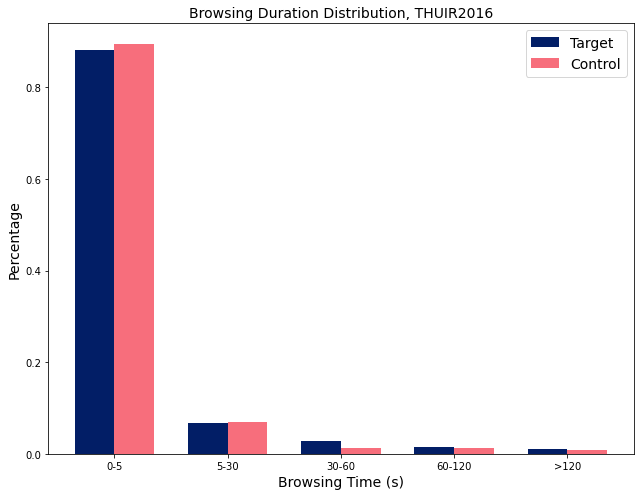

In [65]:
import matplotlib.pyplot as plt

# Extract rank, click, usefulness, and last_time values
def extract_values(data):
    ranks = [item['rank'] for item in data]
    clicks = [item['click'] for item in data]
    usefulness = [item['usefulness'] for item in data]
    last_times = [item['last_time'] for item in data]
    return ranks, clicks, usefulness, last_times

# Function to group last_time into categories
def group_last_time(last_times):
    grouped_last_times = []
    for time in last_times:
        if time <= 5:
            grouped_last_times.append('0-5')
        elif time <= 30:
            grouped_last_times.append('5-30')
        elif time <= 60:
            grouped_last_times.append('30-60')
        elif time <= 120:
            grouped_last_times.append('60-120')
        else:
            grouped_last_times.append('>120')
    return grouped_last_times

# Adjust the percentage calculation to account for ordering
def calculate_percentage_ordered(values, unique_values):
    total_len = len(values)
    return [values.count(val) / total_len for val in unique_values]

# Extract and group last_time values
target_ranks, target_clicks, target_usefulness, target_last_times = extract_values(target_doc_interaction)
control_ranks, control_clicks, control_usefulness, control_last_times = extract_values(control_doc_interaction)

target_grouped_last_times = group_last_time(target_last_times)
control_grouped_last_times = group_last_time(control_last_times)

# Get unique values for ordering
last_time_labels = ['0-5', '5-30', '30-60', '60-120', '>120']

# Calculate ordered percentages
target_last_times_percentage = calculate_percentage_ordered(target_grouped_last_times, last_time_labels)
control_last_times_percentage = calculate_percentage_ordered(control_grouped_last_times, last_time_labels)

# Plot and save chart
plot_and_save_chart(last_time_labels, target_last_times_percentage, control_last_times_percentage,
                    'Browsing Duration Distribution, THUIR2016', 'Browsing Time (s)', 'Percentage',
                    'thuir2_time', '#021E66', '#F76E7C',(9,7))

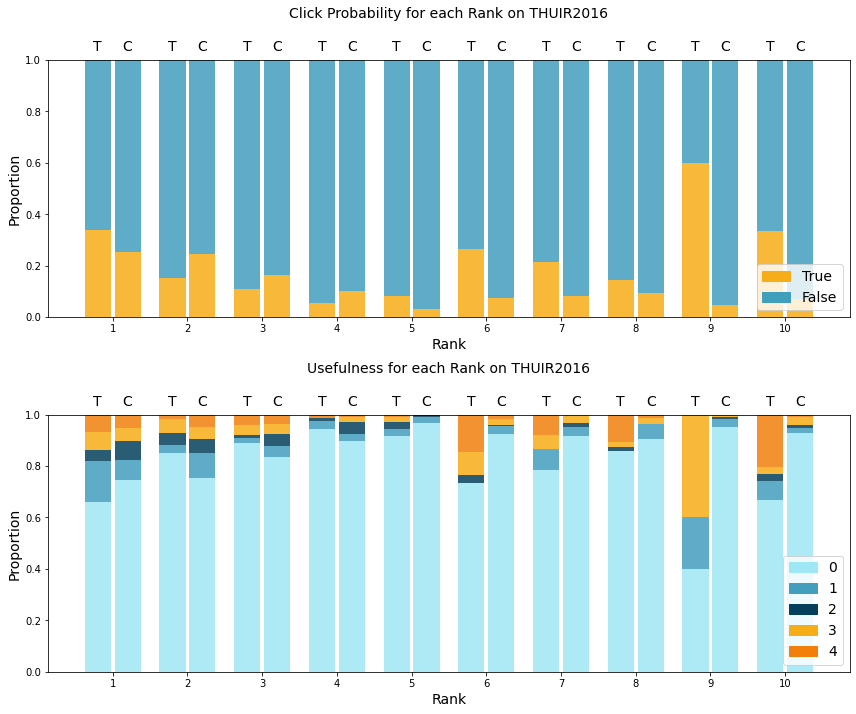

In [29]:
import os
# Color mapping for click values
click_color_mapping = {'True': '#F7AD19', 'False': '#429EBD'}
usefulness_color_mapping = {0: '#9FE7F5', 1: '#429EBD', 2: '#053F5C', 3: '#F7AD19', 4: '#F27F0C'}

# To store the proportions of click True/False for each rank for control group
control_click_proportions = {}

# To store the proportions of usefulness 0/1/2/3/4 for each rank for control group
control_usefulness_proportions = {}

# Function to calculate the proportions for click and usefulness for given data
def calculate_proportions(data, click_proportions, usefulness_proportions):
    for entry in data:
        rank = entry['rank'] + 1
        click = entry['click']
        usefulness = entry['usefulness']

        # Initialize the dictionaries if the rank is encountered for the first time
        if rank not in click_proportions:
            click_proportions[rank] = {'True': 0, 'False': 0}
        if rank not in usefulness_proportions:
            usefulness_proportions[rank] = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0}

        # Increment the count of click True/False and usefulness 0/1/2/3/4 for the respective rank
        click_proportions[rank][str(click)] += 1
        usefulness_proportions[rank][usefulness] += 1

    # Calculate the proportions
    for rank in click_proportions:
        total = sum(click_proportions[rank].values())
        click_proportions[rank] = {k: v / total for k, v in click_proportions[rank].items()}

    for rank in usefulness_proportions:
        total = sum(usefulness_proportions[rank].values())
        usefulness_proportions[rank] = {k: v / total for k, v in usefulness_proportions[rank].items()}

    return click_proportions, usefulness_proportions

# Calculating proportions for target and control data
click_proportions, usefulness_proportions = calculate_proportions(target_doc_interaction, {}, {})
control_click_proportions, control_usefulness_proportions = calculate_proportions(control_doc_interaction, {}, {})

# Function to plot histograms with separate bars for target and control for each rank
def plot_histogram(ax, target_proportions, control_proportions, title, ylabel, unique_values, color_mapping):
    all_ranks = sorted(set(target_proportions.keys()).union(control_proportions.keys()))
    bar_width = 0.35  # the width of the bars
    gap_width = 0.05  # the gap between bars of target and control
    
    for rank in all_ranks:
        target_values = target_proportions.get(rank, {})
        control_values = control_proportions.get(rank, {})
        
        # Position of the bars
        target_position = rank - (bar_width + gap_width) / 2
        control_position = rank + (bar_width + gap_width) / 2
        
        # Plotting bars for target
        bottom = 0
        for value in unique_values:
            proportion = target_values.get(value, 0)
            ax.bar(target_position, proportion, width=bar_width, color=color_mapping[value], bottom=bottom, alpha=0.85)
            bottom += proportion
        
        # Plotting bars for control
        bottom = 0
        for value in unique_values:
            proportion = control_values.get(value, 0)
            ax.bar(control_position, proportion, width=bar_width, color=color_mapping[value], bottom=bottom, alpha=0.85)
            bottom += proportion
    
    ax.set_xlabel('Rank', fontsize=14)
    ax.set_ylim(0, 1)
    ax.set_ylabel(ylabel, fontsize=14)
    ax.set_title(title, y=1.14, fontsize=14)
    ax.set_xticks(all_ranks)
    
    # Adding text to indicate which bar is target and which is control
    for rank in all_ranks:
        ax.text(rank - (bar_width + gap_width) / 2, 1.05, 'T', ha='center', va='center', fontsize=14, transform=ax.get_xaxis_transform())
        ax.text(rank + (bar_width + gap_width) / 2, 1.05, 'C', ha='center', va='center', fontsize=14, transform=ax.get_xaxis_transform())
    
    # Simplified legend
    legend_labels = {v: k for k, v in color_mapping.items()}
    handles = [plt.Rectangle((0, 0), 1, 1, color=color) for color in color_mapping.values()]
    ax.legend(handles, [legend_labels[color] for color in color_mapping.values()], loc='lower right', fontsize=14)


# Creating subplots
fig, axs = plt.subplots(2, 1, figsize=(12, 10))

# Plotting the histogram for Click Proportions
plot_histogram(axs[0], click_proportions, control_click_proportions, 'Click Probability for each Rank on THUIR2016', 'Proportion', ['True', 'False'], click_color_mapping)

# Plotting the histogram for Usefulness Proportions
plot_histogram(axs[1], usefulness_proportions, control_usefulness_proportions, 'Usefulness for each Rank on THUIR2016', 'Proportion', [0, 1, 2, 3, 4], usefulness_color_mapping)

plt.tight_layout()


# Function to save the histograms to files
def save_histogram(target_proportions, control_proportions, title, ylabel, unique_values, color_mapping, filename):
    fig, ax = plt.subplots(figsize=(10, 4))
    plot_histogram(ax, target_proportions, control_proportions, title, ylabel, unique_values, color_mapping)
    plt.tight_layout()
    #plt.show()
    plt.savefig(filename)
    plt.close(fig)

# Saving the histogram for Click Proportions
click_plot_filepath = save_histogram(click_proportions, control_click_proportions, 'Click probability for each rank on THUIR2016', 'Proportion', ['True', 'False'], click_color_mapping, './output/fig/thuir2_click_proportions_plot.pdf')

# Saving the histogram for Usefulness Proportions
usefulness_plot_filepath = save_histogram(usefulness_proportions, control_usefulness_proportions, 'Usefulness for each rank on THUIR2016', 'Proportion', [0, 1, 2, 3, 4], usefulness_color_mapping, './output/fig/thuir2_usefulness_proportions_plot.pdf')







In [30]:
# Define the bins for mapping the last_time to discrete intervals
bins = [0, 5, 30, 60, 120, float('inf')]
labels = ['0-5', '5-30', '30-60', '60-120', '>120']

# Function to map the last_time to discrete intervals
def map_last_time_to_interval(data):
    last_time_intervals = {}
    for entry in data:
        rank = entry['rank']
        last_time = entry['last_time']
        
        # Find the corresponding interval for the last_time
        for i, b in enumerate(bins):
            if last_time <= b:
                interval = labels[i] if i == 0 else labels[i - 1]
                break
        
        # Update the last_time_intervals dictionary
        if rank not in last_time_intervals:
            last_time_intervals[rank] = {label: 0 for label in labels}
        last_time_intervals[rank][interval] += 1
        
    # Calculate proportions for each rank
    for rank, intervals in last_time_intervals.items():
        total = sum(intervals.values())
        last_time_intervals[rank] = {interval: count / total for interval, count in intervals.items()}
    
    return last_time_intervals

# Map the last_time to discrete intervals for target and control groups
target_last_time_intervals = map_last_time_to_interval(target_doc_interaction)
control_last_time_intervals = map_last_time_to_interval(control_doc_interaction)
#print(control_last_time_intervals)
# Color mapping for last_time values
last_time_color_mapping = {'0-5': '#83739E', '5-30': '#018F9C', '30-60': '#FE7B72', '60-120': '#FDC3BE',  '>120': '#FFE494'}

# Saving the histogram for Last Time Proportions
last_time_plot_filepath = save_histogram(target_last_time_intervals, control_last_time_intervals, 'Browsing time for each rank on THUIR2016', 'Proportion', labels, last_time_color_mapping, './output/fig/thuir2_last_time_proportions_plot.pdf')

# Returning the file path of the saved plot
last_time_plot_filepath

In [31]:
from scipy import stats
from scipy.stats import chi2_contingency
import collections

target_rank = [entry['rank'] for entry in target_doc_interaction]
control_rank = [entry['rank'] for entry in control_doc_interaction]

# Count the frequency of each rank in both target and control groups
target_rank_count = collections.Counter(target_rank)
control_rank_count = collections.Counter(control_rank)

# Create a list of all unique ranks
all_ranks = list(set(target_rank + control_rank))

# Create frequency lists for target and control, ensuring each rank is represented
target_freq = [target_rank_count.get(rank, 0) for rank in all_ranks]
control_freq = [control_rank_count.get(rank, 0) for rank in all_ranks]

# Perform Chi-Square Test
chi2, p_value, _, _ = chi2_contingency([target_freq, control_freq])

chi2, p_value

(225.79392276739765, 1.2640626835628113e-43)

In [32]:



# Calculate metrics for a given interaction list
def calculate_metrics(interaction_list):
    click_probs = [1 if interaction['click'] else 0 for interaction in interaction_list]
    avg_click_prob = sum(click_probs) / len(interaction_list)

    browsing_times = [interaction['last_time'] if interaction['click'] else 0 for interaction in interaction_list]
    avg_browsing_time = sum(browsing_times) / len(interaction_list)

    usefulness_scores = [interaction['usefulness'] for interaction in interaction_list]
    avg_usefulness = sum(usefulness_scores) / len(interaction_list)
    
    ranks = [entry['rank'] for entry in interaction_list]
    avg_rank = np.mean(ranks)
    
    return avg_click_prob, avg_browsing_time, avg_usefulness, avg_rank

# Calculate the metrics for both interaction lists
target_avg_click_prob, target_avg_browsing_time, target_avg_usefulness, target_avg_rank = calculate_metrics(target_doc_interaction)
control_avg_click_prob, control_avg_browsing_time, control_avg_usefulness, control_avg_rank = calculate_metrics(control_doc_interaction)

# Conduct t-tests to compare the means
click_prob_t_stat, click_prob_p_val = stats.ttest_ind([interaction['click'] for interaction in target_doc_interaction],
                                                     [interaction['click'] for interaction in control_doc_interaction])

browsing_time_t_stat, browsing_time_p_val = stats.ttest_ind(
    [interaction['last_time'] if interaction['click'] else 0 for interaction in target_doc_interaction],
    [interaction['last_time'] if interaction['click'] else 0 for interaction in control_doc_interaction]
)

usefulness_t_stat, usefulness_p_val = stats.ttest_ind([interaction['usefulness'] for interaction in target_doc_interaction],
                                                     [interaction['usefulness'] for interaction in control_doc_interaction])


rank_t_stat, rank_p_val = stats.ttest_ind([interaction['rank'] for interaction in target_doc_interaction],
                                                     [interaction['rank'] for interaction in control_doc_interaction])

{
    "target_metrics": {
        "avg_click_prob": target_avg_click_prob,
        "avg_browsing_time": target_avg_browsing_time,
        "avg_usefulness": target_avg_usefulness,
        "avg_rank": target_avg_rank,
    },
    "control_metrics": {
        "avg_click_prob": control_avg_click_prob,
        "avg_browsing_time": control_avg_browsing_time,
        "avg_usefulness": control_avg_usefulness,
        "avg_rank": control_avg_rank,
    },
    "t_test_results": {
        "click_prob": {"t_stat": click_prob_t_stat, "p_val": click_prob_p_val},
        "browsing_time": {"t_stat": browsing_time_t_stat, "p_val": browsing_time_p_val},
        "usefulness": {"t_stat": usefulness_t_stat, "p_val": usefulness_p_val},
        "rank": {"t_stat": rank_t_stat, "p_val": rank_p_val},
    }
}

{'target_metrics': {'avg_click_prob': 0.14627285513361463,
  'avg_browsing_time': 5.781949367088608,
  'avg_usefulness': 0.38396624472573837,
  'avg_rank': 3.4036568213783402},
 'control_metrics': {'avg_click_prob': 0.13705179282868526,
  'avg_browsing_time': 4.196602390438247,
  'avg_usefulness': 0.3051792828685259,
  'avg_rank': 3.7721115537848604},
 't_test_results': {'click_prob': {'t_stat': 0.5652567954319035,
   'p_val': 0.5719636733167579},
  'browsing_time': {'t_stat': 1.445288813072269, 'p_val': 0.14853631220976862},
  'usefulness': {'t_stat': 1.7986831784417008, 'p_val': 0.07222229606908728},
  'rank': {'t_stat': -2.872528365632911, 'p_val': 0.0041157267480025055}}}

In [33]:
# Split the interactions into three groups based on rank
def split_by_rank(interactions):
    group1 = [item for item in interactions if 0 <= item['rank'] <= 4]
    group2 = [item for item in interactions if 5 <= item['rank'] <= 9]
    return group1, group2

# Split target and control interactions by rank
target_groups = split_by_rank(target_doc_interaction)
control_groups = split_by_rank(control_doc_interaction)

# Calculate metrics for each group and perform t-tests
results = []

for i in range(2):
    target_metrics = calculate_metrics(target_groups[i])
    control_metrics = calculate_metrics(control_groups[i])

    click_prob_ttest = stats.ttest_ind([entry['click'] for entry in target_groups[i]], [entry['click'] for entry in control_groups[i]])
    rank_ttest = stats.ttest_ind([entry['rank'] for entry in target_groups[i]], [entry['rank'] for entry in control_groups[i]])
    view_time_ttest = stats.ttest_ind([entry['last_time'] if entry['click'] else 0 for entry in target_groups[i]], 
                                [entry['last_time'] if entry['click'] else 0 for entry in control_groups[i]])
    usefulness_ttest = stats.ttest_ind([entry['usefulness'] for entry in target_groups[i]], [entry['usefulness'] for entry in control_groups[i]])

    results.append({
        'group': i+1,
        'target_metrics': target_metrics,
        'control_metrics': control_metrics,
        'click_prob_ttest': click_prob_ttest,
        'view_time_ttest': view_time_ttest,
        'usefulness_ttest': usefulness_ttest,
        'rank_ttest': rank_ttest,
    })

results

[{'group': 1,
  'target_metrics': (0.11666666666666667,
   3.3253740740740754,
   0.26851851851851855,
   2.3055555555555554),
  'control_metrics': (0.1830601092896175,
   5.6402199453551916,
   0.412568306010929,
   1.6120218579234973),
  'click_prob_ttest': Ttest_indResult(statistic=-3.2459075445647, pvalue=0.0012013117729432548),
  'view_time_ttest': Ttest_indResult(statistic=-1.8445598037302966, pvalue=0.06533434994038285),
  'usefulness_ttest': Ttest_indResult(statistic=-2.734155836815097, pvalue=0.006340967888816395),
  'rank_ttest': Ttest_indResult(statistic=9.305048469188696, pvalue=5.679565302001884e-20)},
 {'group': 2,
  'target_metrics': (0.23976608187134502,
   13.539555555555559,
   0.7485380116959064,
   6.871345029239766),
  'control_metrics': (0.07265774378585087,
   2.1760898661567873,
   0.15487571701720843,
   6.795411089866157),
  'click_prob_ttest': Ttest_indResult(statistic=6.123619272774468, pvalue=1.5331612830731818e-09),
  'view_time_ttest': Ttest_indResult(sta

## Chi-square test

In [34]:
from scipy import stats
from scipy.stats import chi2_contingency
import collections

target_rank = [entry['rank'] for entry in target_doc_interaction]
control_rank = [entry['rank'] for entry in control_doc_interaction]

# Count the frequency of each rank in both target and control groups
target_rank_count = collections.Counter(target_rank)
control_rank_count = collections.Counter(control_rank)

# Create a list of all unique ranks
all_ranks = list(set(target_rank + control_rank))

# Create frequency lists for target and control, ensuring each rank is represented
target_freq = [target_rank_count.get(rank, 0) for rank in all_ranks]
control_freq = [control_rank_count.get(rank, 0) for rank in all_ranks]

# Perform Chi-Square Test
chi2, p_value, _, _ = chi2_contingency([target_freq, control_freq])

chi2, p_value

(225.79392276739765, 1.2640626835628113e-43)

# Effect of Decoy - logistic regression

In [35]:
# 交叉项

## merge data

In [58]:
import pandas as pd
from sklearn.linear_model import LogisticRegression


#Add 'has_decoy' attribute and merge the two lists
for entry in control_doc_interaction:
    entry['has_decoy'] = 0

for entry in target_doc_interaction:
    entry['has_decoy'] = 1

merged_data = control_doc_interaction + target_doc_interaction

# Convert the merged data to a DataFrame for easier manipulation
df = pd.DataFrame(merged_data)

# Create dummy variables for categorical variables
dummy_fields = ['rank', 
                'task_id', 'student_id', 
                #'relevance'
               ]
for field in dummy_fields:
    dummies = pd.get_dummies(df[field], prefix=field, drop_first=True)
    df = pd.concat([df, dummies], axis=1)

# Drop original categorical fields and other non-predictor fields
fields_to_drop = ['docno', 'rank', 'last_time', 'usefulness', 'student_id', 'task_id', 'relevance']
df = df.drop(fields_to_drop, axis=1)



In [59]:
from sklearn.linear_model import LogisticRegression

# Features (X) and Labels (y) for 'click'
X_click = df.drop(['click'], axis=1)
y_click = df['click']


In [60]:
from sklearn.feature_selection import VarianceThreshold

def variance_threshold_selector(data, threshold=0.5):
    # https://stackoverflow.com/a/39813304/1956309
    selector = VarianceThreshold(threshold)
    selector.fit(data)
    return data[data.columns[selector.get_support(indices=True)]]

# min_variance = .9 * (1 - .9)  # You can play here with different values.
min_variance = 0.1
low_variance = variance_threshold_selector(df, min_variance) 
print('columns removed:')
df.columns ^ low_variance.columns
df.shape
df.shape
X = low_variance

columns removed:


/var/folders/7k/8q9xq4596mb6rkfh3c6gknc00000gn/T/ipykernel_60355/3194216113.py:13: FutureWarning: Index.__xor__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__xor__.  Use index.symmetric_difference(other) instead.
  df.columns ^ low_variance.columns


In [61]:
import statsmodels.api as sm

# Add constant for intercept term
X_click_const = sm.add_constant(X_click)

# Logistic regression for 'click'
logit_model_click = sm.Logit(y_click, X_click_const)
result_click = logit_model_click.fit(disp=0)


# Summary tables, which include p-values
summary_click = result_click.summary()

summary_click

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  click   No. Observations:                 1966
Model:                          Logit   Df Residuals:                     1923
Method:                           MLE   Df Model:                           42
Date:                Wed, 11 Oct 2023   Pseudo R-squ.:                  0.1440
Time:                        20:56:37   Log-Likelihood:                -682.67
converged:                       True   LL-Null:                       -797.54
Covariance Type:            nonrobust   LLR p-value:                 1.034e-27
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -1.4247      0.442     -3.226      0.001      -2.290      -0.559
has_decoy         0.4402      0.164      2.692      0.007       0.120       0.761
rank_1           -0.5007      0.224     -2.240      0.025      -0.939      -0.063
rank_2           -0.8925      0.246     -3.633      0.000      -1.374      -0.411
rank_3           -1.8479      0.299     -6.178      0.000      -2.434      -1.262
rank_4           -2.2463      0.363     -6.180      0.000      -2.959      -1.534
rank_5           -1.4203      0.294     -4.830      0.000      -1.997      -0.844
rank_6           -0.9389      0.356     -2.640      0.008      -1.636      -0.242
rank_7           -1.1598      0.330     -3.517      0.000      -1.806      -0.513
rank_8           -1.7219      0.414     -4.158      0.000      -2.533      -0.910
rank_9           -0.8593      0.302     -2.841      0.004      -1.452      -0.267
task_id_10        0.8253      0.357      2.313      0.021       0.126       1.525
task_id_11        0.5979      0.277      2.156      0.031       0.054       1.141
task_id_12        0.7419      0.355      2.089      0.037       0.046       1.438
task_id_2         0.5443      0.314      1.732      0.083      -0.071       1.160
task_id_3        -0.0665      0.289     -0.231      0.818      -0.632       0.499
task_id_4        -0.0819      0.380     -0.216      0.829      -0.826       0.662
task_id_7        -0.0177      0.337     -0.053      0.958      -0.677       0.642
task_id_8         1.2239      0.355      3.448      0.001       0.528       1.920
student_id_10     0.4643      0.478      0.971      0.331      -0.473       1.401
student_id_11    -0.0420      0.482     -0.087      0.931      -0.986       0.902
student_id_12     1.5011      0.421      3.568      0.000       0.676       2.326
student_id_13     0.1767      0.500      0.353      0.724      -0.803       1.157
student_id_14    -1.3573      0.691     -1.964      0.050      -2.712      -0.003
student_id_15    -0.0235      0.456     -0.052      0.959      -0.916       0.869
student_id_16    -1.5450      0.583     -2.648      0.008      -2.688      -0.402
student_id_17     0.2860      0.492      0.581      0.561      -0.679       1.251
student_id_18     0.1683      0.471      0.357      0.721      -0.756       1.092
student_id_19    -2.2238      0.802     -2.773      0.006      -3.796      -0.652
student_id_2     -0.1690      0.526     -0.321      0.748      -1.199       0.861
student_id_20    -1.2314      0.697     -1.767      0.077      -2.598       0.135
student_id_21     0.2717      0.459      0.591      0.554      -0.629       1.172
student_id_22     0.4406      0.508      0.867      0.386      -0.555       1.436
student_id_23     0.6480      0.488      1.327      0.184      -0.309       1.605
student_id_24     0.2020      0.438      0.462      0.644      -0.655       1.060
student_id_25     0.3555      0.484      0.735      0.463      -0.593       1.304
student_id_3     -0.1008      0.509     -0.

In [56]:
# Convert the merged data to a DataFrame for easier manipulation
merged_df = pd.DataFrame(merged_data)

# Create dummy variables for categorical variables
dummy_fields_ols = ['rank', 'task_id', 'student_id',
                     #'relevance'
                   ]
for field in dummy_fields_ols:
    dummies = pd.get_dummies(merged_df[field], prefix=field, drop_first=True)
    merged_df = pd.concat([merged_df, dummies], axis=1)

# Drop original categorical fields
fields_to_drop_ols = ['docno', 'click',  'student_id', 'task_id', 'relevance', 'rank']
df_ols = merged_df.drop(fields_to_drop_ols, axis=1)

# Show the first few rows to confirm the changes
df_ols.head()

,last_time,usefulness,has_decoy,rank_1,rank_2,rank_3,rank_4,rank_5,rank_6,rank_7,...,student_id_23,student_id_24,student_id_25,student_id_3,student_id_4,student_id_5,student_id_6,student_id_7,student_id_8,student_id_9
0,0.0,0.0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.0,0.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.0,0.0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.0,0.0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.0,0.0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [57]:
import statsmodels.api as sm

# Features (X) and Labels (y) for 'last_time'
X_last_time = df_ols.drop(['last_time', 'usefulness'], axis=1)
y_last_time = df_ols['last_time']

# Add constant for intercept term
X_last_time_const = sm.add_constant(X_last_time)

# OLS regression for 'last_time'
ols_model_last_time = sm.OLS(y_last_time, X_last_time_const)
result_last_time = ols_model_last_time.fit()

# Summary table, which includes p-values
summary_last_time = result_last_time.summary()
summary_last_time

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              last_time   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     2.070
Date:                Wed, 11 Oct 2023   Prob (F-statistic):           7.53e-05
Time:                        20:56:00   Log-Likelihood:                -8941.9
No. Observations:                1966   AIC:                         1.797e+04
Df Residuals:                    1923   BIC:                         1.821e+04
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             9.1982      3.423      2.687      0.007       2.485      15.911
has_decoy         2.7104      1.234      2.197      0.028       0.291       5.130
rank_1           -3.1036      2.036     -1.524      0.128      -7.097       0.890
rank_2           -1.0193      2.079     -0.490      0.624      -5.096       3.057
rank_3           -6.2395      2.121     -2.942      0.003     -10.399      -2.080
rank_4           -7.5240      2.308     -3.260      0.001     -12.051      -2.997
rank_5           -0.8971      2.241     -0.400      0.689      -5.293       3.499
rank_6           -6.4943      2.822     -2.301      0.021     -12.029      -0.960
rank_7           -4.7646      2.527     -1.886      0.059      -9.720       0.190
rank_8           -4.6387      2.679     -1.731      0.084      -9.894       0.616
rank_9           -1.3543      2.480     -0.546      0.585      -6.218       3.509
task_id_10        0.8843      2.836      0.312      0.755      -4.678       6.446
task_id_11       -0.1260      2.019     -0.062      0.950      -4.086       3.834
task_id_12        8.9993      2.614      3.442      0.001       3.872      14.126
task_id_2         3.5161      2.280      1.542      0.123      -0.956       7.988
task_id_3        -2.9235      2.029     -1.441      0.150      -6.902       1.055
task_id_4         2.7590      2.531      1.090      0.276      -2.205       7.723
task_id_7         1.7412      2.327      0.748      0.454      -2.822       6.304
task_id_8         4.0144      2.736      1.467      0.142      -1.352       9.380
student_id_10    -2.1772      3.990     -0.546      0.585     -10.003       5.649
student_id_11    -2.8254      3.747     -0.754      0.451     -10.173       4.522
student_id_12     1.0514      3.631      0.290      0.772      -6.071       8.173
student_id_13    -1.1844      3.962     -0.299      0.765      -8.955       6.586
student_id_14    -6.9492      3.783     -1.837      0.066     -14.368       0.470
student_id_15    -0.5424      3.487     -0.156      0.876      -7.381       6.296
student_id_16    -6.9512      3.393     -2.049      0.041     -13.606      -0.296
student_id_17    -4.1531      3.763     -1.104      0.270     -11.533       3.227
student_id_18    -5.0742      3.702     -1.371      0.171     -12.334       2.186
student_id_19    -7.7709      3.518     -2.209      0.027     -14.670      -0.872
student_id_2     -3.4793      3.907     -0.891      0.373     -11.142       4.183
student_id_20    -6.4173      4.004     -1.603      0.109     -14.270       1.436
student_id_21    -1.0484      3.635     -0.288      0.773      -8.177       6.080
student_id_22     1.6682      4.156      0.401      0.688      -6.483       9.819
student_id_23     2.0572      4.071      0.505      0.613      -5.926      10.041
student_id_24    -1.8531      3.426     -0.541   

In [42]:
# Features (X) and Labels (y) for 'usefulness'
X_usefulness = df_ols.drop(['last_time','usefulness'], axis=1)
y_usefulness = df_ols['usefulness']

# Add constant for intercept term
X_usefulness_const = sm.add_constant(X_usefulness)

# OLS regression for 'usefulness'
ols_model_usefulness = sm.OLS(y_usefulness, X_usefulness_const)
result_usefulness = ols_model_usefulness.fit()

# Summary table, which includes p-values
summary_usefulness = result_usefulness.summary()
summary_usefulness

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             usefulness   R-squared:                       0.103
Model:                            OLS   Adj. R-squared:                  0.083
Method:                 Least Squares   F-statistic:                     5.236
Date:                Wed, 11 Oct 2023   Prob (F-statistic):           2.90e-24
Time:                        20:48:32   Log-Likelihood:                -2547.8
No. Observations:                1966   AIC:                             5182.
Df Residuals:                    1923   BIC:                             5422.
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.5293      0.132      3.997      0.000       0.270       0.789
has_decoy         0.1712      0.048      3.587      0.000       0.078       0.265
rank_1           -0.1825      0.079     -2.317      0.021      -0.337      -0.028
rank_2           -0.2652      0.080     -3.298      0.001      -0.423      -0.108
rank_3           -0.5254      0.082     -6.404      0.000      -0.686      -0.365
rank_4           -0.5833      0.089     -6.532      0.000      -0.758      -0.408
rank_5           -0.3343      0.087     -3.855      0.000      -0.504      -0.164
rank_6           -0.3168      0.109     -2.902      0.004      -0.531      -0.103
rank_7           -0.3302      0.098     -3.378      0.001      -0.522      -0.139
rank_8           -0.4581      0.104     -4.419      0.000      -0.661      -0.255
rank_9           -0.1978      0.096     -2.062      0.039      -0.386      -0.010
task_id_10        0.2805      0.110      2.557      0.011       0.065       0.496
task_id_11        0.0611      0.078      0.782      0.435      -0.092       0.214
task_id_12        0.1153      0.101      1.140      0.254      -0.083       0.314
task_id_2         0.0815      0.088      0.924      0.356      -0.092       0.254
task_id_3        -0.0831      0.078     -1.059      0.290      -0.237       0.071
task_id_4        -0.0282      0.098     -0.288      0.773      -0.220       0.164
task_id_7         0.0455      0.090      0.506      0.613      -0.131       0.222
task_id_8         0.2912      0.106      2.751      0.006       0.084       0.499
student_id_10     0.0879      0.154      0.569      0.569      -0.215       0.391
student_id_11    -0.1032      0.145     -0.712      0.476      -0.387       0.181
student_id_12     0.6704      0.140      4.772      0.000       0.395       0.946
student_id_13    -0.0615      0.153     -0.401      0.688      -0.362       0.239
student_id_14    -0.2373      0.146     -1.622      0.105      -0.524       0.050
student_id_15     0.0115      0.135      0.086      0.932      -0.253       0.276
student_id_16    -0.2463      0.131     -1.877      0.061      -0.504       0.011
student_id_17     0.1441      0.146      0.990      0.323      -0.141       0.430
student_id_18    -0.0260      0.143     -0.182      0.856      -0.307       0.255
student_id_19    -0.2878      0.136     -2.115      0.035      -0.555      -0.021
student_id_2     -0.0204      0.151     -0.135      0.893      -0.317       0.276
student_id_20    -0.2408      0.155     -1.554      0.120      -0.545       0.063
student_id_21     0.0035      0.141      0.025      0.980      -0.272       0.279
student_id_22     0.1780      0.161      1.107      0.268      -0.137       0.493
student_id_23     0.3486      0.157      2.214      0.027       0.040       0.657
student_id_24     0.0044      0.133      0.033   

# Effect of Decoy (distance?)

In [43]:
# distance from decoy to target
# relevance difference between decoy and target
# similarity between decoy and target

In [44]:
# Initialize the maps
improved_target_map = {}
#improved_decoy_map = {}

for item in decoy_pair:
    # Keys for target and decoy maps
    key_t = (item['session_num'], item['interaction_num'], item['docno_target'])
    key_d = (item['session_num'], item['interaction_num'], item['docno_decoy'])
    
    # Calculate similarity
    docno1, docno2 = sorted([item['docno_target'], item['docno_decoy']])
    similarity_value = similarity_scores.get(docno1, {}).get(docno2, 0)
    
    # New data to be inserted/updated
    new_data = {
        'docno_target': item['docno_target'],
        'rank_target': item['rank_target'],
        'docno_decoy': item['docno_decoy'],
        'rank_decoy': item['rank_decoy'],
        'relevance_target': relevance_data.get(item['docno_target'], 0),
        'relevance_decoy': relevance_data.get(item['docno_decoy'], 0),
        'similarity': similarity_value
    }
    
    # Update the target map
    update_flag = False  # To keep track if we should also update the decoy map
    if key_t in improved_target_map:
        #print("Target document with more than 1 decoys." +
        #    "new: %d existing %d"%(int(item['rank_decoy']), int(improved_target_map[key_t]['rank_decoy'])))
        if int(item['rank_decoy']) < int(improved_target_map[key_t]['rank_decoy']):
            improved_target_map[key_t] = new_data
            update_flag = True  # We found a better rank for decoy, so we should update the decoy map as well
    else:
        improved_target_map[key_t] = new_data
    
    # Update the decoy map only if we found a better rank for decoy
    if update_flag:
        #print('decoy update!')
        # Remove the previous entry from decoy map
        old_key_d = (item['session_num'], item['interaction_num'], improved_target_map[key_t]['docno_decoy'])
        #if old_key_d in improved_decoy_map:
        #    del improved_decoy_map[old_key_d]
        
    # Add the new entry to decoy map
    #improved_decoy_map[key_d] = new_data

# Print some items for review
print("Improved Target Map:")
print(len(improved_target_map))
print(dict(list(improved_target_map.items())[:5]))
#print("\nImproved Decoy Map:")
#print(len(improved_decoy_map))
#print(dict(list(improved_decoy_map.items())[:5]))

Improved Target Map:
812
{('1', '1', '2'): {'docno_target': '2', 'rank_target': '1', 'docno_decoy': '6', 'rank_decoy': '5', 'relevance_target': 3, 'relevance_decoy': 0, 'similarity': 0.6524626787562728}, ('1', '1', '3'): {'docno_target': '3', 'rank_target': '2', 'docno_decoy': '6', 'rank_decoy': '5', 'relevance_target': 4, 'relevance_decoy': 0, 'similarity': 0.6993424523066978}, ('1', '1', '4'): {'docno_target': '4', 'rank_target': '3', 'docno_decoy': '6', 'rank_decoy': '5', 'relevance_target': 3, 'relevance_decoy': 0, 'similarity': 0.7971005117075741}, ('1', '1', '8'): {'docno_target': '8', 'rank_target': '7', 'docno_decoy': '6', 'rank_decoy': '5', 'relevance_target': 3, 'relevance_decoy': 0, 'similarity': 0.8386688553592245}, ('1', '3', '16145'): {'docno_target': '16145', 'rank_target': '0', 'docno_decoy': '16146', 'rank_decoy': '1', 'relevance_target': 3, 'relevance_decoy': 0, 'similarity': 0.662526588301587}}


In [45]:
def process_target_decoy_pair(results, decoy_target_record, session_num, interaction_num, user_id, topic_id):
    """
    Process the results to extract required information.
    """
    interactions_list = []
    clicked_items = []
    if "clicked" in interaction and "click" in interaction["clicked"]:
        clicked_items = interaction["clicked"]["click"]
        
    for item in results:
        #record_id = session_num + '_' + interaction_num + '_' + item['id']
        key = (session_num, interaction_num, item['id'])
        if key in improved_target_map and int(item['rank']) < CUTOFF:
            # used_keys.add(key)
            pair = improved_target_map[key]
            similarity = pair['similarity']

            target_docno = pair['docno_target']
            target_clicked = False
            target_last_time = 0
            target_relevance = pair['relevance_target']
            target_rank = pair['rank_target']
            target_usefulness = 0

            decoy_docno = pair['docno_decoy']
            decoy_clicked = False
            decoy_last_time = 0
            decoy_relevance = pair['relevance_decoy']  
            decoy_rank = pair['rank_decoy']
            decoy_usefulness = 0

            for click_item in clicked_items:
                if isinstance(click_item, dict) and target_docno == click_item["docno"]:
                    target_clicked = True
                    endtime = float(click_item['endtime'])
                    starttime = float(click_item['starttime'])
                    target_last_time = endtime - starttime
                    target_usefulness = float(click_item["annotation"]['score'])
                if isinstance(click_item, dict) and decoy_docno == click_item["docno"]:
                    decoy_clicked = True
                    endtime = float(click_item['endtime'])
                    starttime = float(click_item['starttime'])
                    decoy_last_time = endtime - starttime
                    decoy_usefulness = float(click_item["annotation"]['score'])
                    
            interactions_list.append({
                                        'task_id': topic_id, 
                                        'student_id': user_id, 
                                        'target_docno': target_docno, 
                                        'decoy_docno': decoy_docno, 
                                        'target_rank':  int(target_rank),
                                        'decoy_rank': int(decoy_rank),
                                        'rank_diff': int(decoy_rank) - int(target_rank),
                                        'target_relevance':  int(target_relevance),
                                        'decoy_relevance': int(decoy_relevance),
                                        'relevance_diff': int(target_relevance) - int(decoy_relevance),
                                        'similarity': similarity,
                                        'target_click':int(target_clicked),
                                        'decoy_click': int(decoy_clicked),
                                        'target_last_time':target_last_time, 
                                        'decoy_last_time':decoy_last_time, 
                                        'target_usefulness': target_usefulness, 
                                        'decoy_usefulness': decoy_usefulness, 
                                     })
                
    return interactions_list


target_decoy_pair_interaction = []

for session in thuir2_ss:
    session_num = session["num"]
    interactions = session["interaction"]
    student_id = session["userid"]
    topic_id = session['topic']['num']
    
    # Check if interactions is a list or a dict
    if isinstance(interactions, list):
        for interaction in interactions:
            interaction_num = interaction["num"]
            if interaction.get("results"):
                results = interaction["results"]["result"]
                interactions_list = process_target_decoy_pair(results, decoy_target_record, session_num, interaction_num, student_id, topic_id)
                target_decoy_pair_interaction.extend(interactions_list)
    
    elif isinstance(interactions, dict):
        interaction_num = interactions["num"]
        if interaction.get("results"):
            results = interactions["results"]["result"]
            interactions_list = process_target_decoy_pair(results, decoy_target_record, session_num, interaction_num, student_id, topic_id)
            target_decoy_pair_interaction.extend(interactions_list)

print(len(target_decoy_pair_interaction))
print(target_decoy_pair_interaction[:3])

802
[{'task_id': '1', 'student_id': '1', 'target_docno': '2', 'decoy_docno': '6', 'target_rank': 1, 'decoy_rank': 5, 'rank_diff': 4, 'target_relevance': 3, 'decoy_relevance': 0, 'relevance_diff': 3, 'similarity': 0.6524626787562728, 'target_click': 0, 'decoy_click': 0, 'target_last_time': 0, 'decoy_last_time': 0, 'target_usefulness': 0, 'decoy_usefulness': 0}, {'task_id': '1', 'student_id': '1', 'target_docno': '3', 'decoy_docno': '6', 'target_rank': 2, 'decoy_rank': 5, 'rank_diff': 3, 'target_relevance': 4, 'decoy_relevance': 0, 'relevance_diff': 4, 'similarity': 0.6993424523066978, 'target_click': 0, 'decoy_click': 0, 'target_last_time': 0, 'decoy_last_time': 0, 'target_usefulness': 0, 'decoy_usefulness': 0}, {'task_id': '1', 'student_id': '1', 'target_docno': '4', 'decoy_docno': '6', 'target_rank': 3, 'decoy_rank': 5, 'rank_diff': 2, 'target_relevance': 3, 'decoy_relevance': 0, 'relevance_diff': 3, 'similarity': 0.7971005117075741, 'target_click': 0, 'decoy_click': 0, 'target_last_t

In [46]:
# Create a DataFrame from the data
df = pd.DataFrame(target_decoy_pair_interaction)
#df_plot =  pd.DataFrame(target_decoy_pair_interaction)

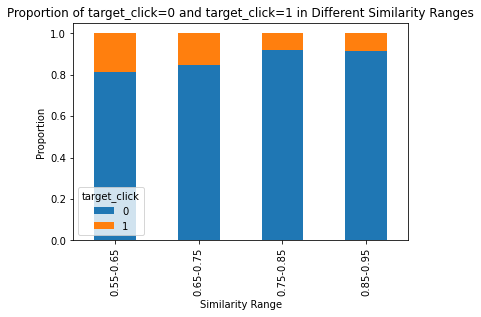

In [47]:
# Create bins for similarity
bins = [0.55, 0.65, 0.75, 0.85, 0.95]

# Assign each row to a bin based on its similarity value
df['similarity_bin'] = pd.cut(df['similarity'], bins, labels=[
    '0.55-0.65', '0.65-0.75', '0.75-0.85', '0.85-0.95'
])

# Group the data by the similarity bin and target_click, then count the number of occurrences of each combination
group_counts = df.groupby(['similarity_bin', 'target_click']).size().reset_index(name='counts')

# Pivot the table to have similarity_bin as rows, target_click as columns, and counts as values
pivot_table = group_counts.pivot(index='similarity_bin', columns='target_click', values='counts').fillna(0)

# Calculate the proportions
pivot_table['total'] = pivot_table.sum(axis=1)
for col in pivot_table.columns[:-1]:
    pivot_table[f'proportion_{col}'] = pivot_table[col] / pivot_table['total']

# Plot the proportions
pivot_table[['proportion_0', 'proportion_1']].plot(kind='bar', stacked=True)
plt.xlabel('Similarity Range')
plt.ylabel('Proportion')
plt.title('Proportion of target_click=0 and target_click=1 in Different Similarity Ranges')
plt.legend(title='target_click', labels=['0', '1'])
plt.show()


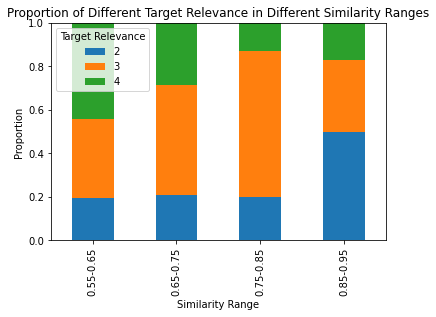

In [48]:
import matplotlib.pyplot as plt


# Assign each row to a bin based on its similarity value
df['similarity_bin'] = pd.cut(df['similarity'], bins, 
                              labels=[ '0.55-0.65', '0.65-0.75', '0.75-0.85', '0.85-0.95'])

# Group the data by the similarity bin and target_relevance, then count the number of occurrences of each combination
group_counts = df.groupby(['similarity_bin', 'target_relevance']).size().reset_index(name='counts')

# Pivot the table to have similarity_bin as rows, target_relevance as columns, and counts as values
pivot_table = group_counts.pivot(index='similarity_bin', columns='target_relevance', values='counts').fillna(0)

# Calculate the proportions
pivot_table['total'] = pivot_table.sum(axis=1)
for col in pivot_table.columns[:-1]:
    pivot_table[f'proportion_{col}'] = pivot_table[col] / pivot_table['total']

# Plot the proportions
pivot_table[['proportion_2','proportion_3', 'proportion_4']].plot(kind='bar', stacked=True)
plt.xlabel('Similarity Range')
plt.ylabel('Proportion')
plt.title('Proportion of Different Target Relevance in Different Similarity Ranges')
plt.legend(title='Target Relevance', labels=['2','3', '4'])
plt.ylim(0, 1)  # Setting y-axis limits from 0 to 1
plt.show()

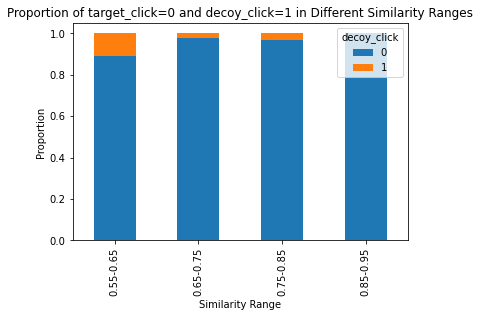

In [49]:
# Create bins for similarity
bins = [0.55, 0.65, 0.75, 0.85, 0.95]

# Group the data by the similarity bin and target_click, then count the number of occurrences of each combination
group_counts = df.groupby(['similarity_bin', 'decoy_click']).size().reset_index(name='counts')

# Pivot the table to have similarity_bin as rows, target_click as columns, and counts as values
pivot_table = group_counts.pivot(index='similarity_bin', columns='decoy_click', values='counts').fillna(0)

# Calculate the proportions
pivot_table['total'] = pivot_table.sum(axis=1)
for col in pivot_table.columns[:-1]:
    pivot_table[f'proportion_{col}'] = pivot_table[col] / pivot_table['total']

# Plot the proportions
pivot_table[['proportion_0', 'proportion_1']].plot(kind='bar', stacked=True)
plt.xlabel('Similarity Range')
plt.ylabel('Proportion')
plt.title('Proportion of target_click=0 and decoy_click=1 in Different Similarity Ranges')
plt.legend(title='decoy_click', labels=['0', '1'])
plt.show()


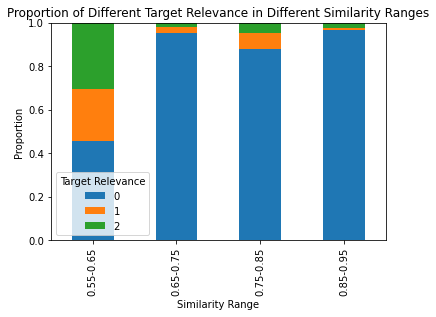

In [50]:
import matplotlib.pyplot as plt


# Assign each row to a bin based on its similarity value
df['similarity_bin'] = pd.cut(df['similarity'], bins, 
                              labels=[ '0.55-0.65', '0.65-0.75', '0.75-0.85', '0.85-0.95'])

# Group the data by the similarity bin and target_relevance, then count the number of occurrences of each combination
group_counts = df.groupby(['similarity_bin', 'decoy_relevance']).size().reset_index(name='counts')

# Pivot the table to have similarity_bin as rows, target_relevance as columns, and counts as values
pivot_table = group_counts.pivot(index='similarity_bin', columns='decoy_relevance', values='counts').fillna(0)

# Calculate the proportions
pivot_table['total'] = pivot_table.sum(axis=1)
for col in pivot_table.columns[:-1]:
    pivot_table[f'proportion_{col}'] = pivot_table[col] / pivot_table['total']

# Plot the proportions
pivot_table[['proportion_0','proportion_1','proportion_2']].plot(kind='bar', stacked=True)
plt.xlabel('Similarity Range')
plt.ylabel('Proportion')
plt.title('Proportion of Different Target Relevance in Different Similarity Ranges')
plt.legend(title='Target Relevance', labels=['0','1', '2'])
plt.ylim(0, 1)  # Setting y-axis limits from 0 to 1
plt.show()

In [51]:
df = pd.DataFrame(target_decoy_pair_interaction)

# Generate dummy variables for 'task_id' and 'student_id'
# Create dummy variables for categorical variables
dummy_fields = [#'target_rank', 
                #'target_relevance',   
                'task_id', 'student_id', 
               ]

for field in dummy_fields:
    dummies = pd.get_dummies(df[field], prefix=field, drop_first=True)
    df = pd.concat([df, dummies], axis=1)
    
# Drop original categorical fields and other non-predictor fields
fields_to_drop = [
                    'similarity',
                    'target_click',
                  'target_docno', 
                  'decoy_docno',
                  #'target_rank', 
                  'decoy_rank', 
                  #'rank_diff',
                  'task_id', 
                  'student_id', 
                  #'target_relevance', 
                  #'decoy_relevance', 
                  'relevance_diff',
                  'decoy_click',
                  'decoy_last_time',
                  'decoy_usefulness', 
                  'target_last_time',  'target_usefulness',
                   'decoy_usefulness',                
                 ]
X = df.drop(fields_to_drop, axis=1)
# Adding the square of the similarity column
X['log_similarity'] = np.log(df['similarity'])
#X['log_similarity_squared'] = X['log_similarity'] ** 2
print(X.columns)
#print(df[['decoy_click']].value_counts())

# Add a constant to the features (required for the statsmodels logistic regression model)
X = sm.add_constant(X)

# Create the target Series (y)
y = df['target_click']

# Fit logistic regression model
model = sm.Logit(y, X)

try:
    result = model.fit()
    summary = result.summary()
except Exception as e:
    summary = str(e)

summary

Index(['target_rank', 'rank_diff', 'target_relevance', 'decoy_relevance',
       'task_id_10', 'task_id_11', 'task_id_12', 'task_id_2', 'task_id_3',
       'task_id_4', 'task_id_7', 'task_id_8', 'student_id_10', 'student_id_11',
       'student_id_12', 'student_id_13', 'student_id_14', 'student_id_15',
       'student_id_16', 'student_id_17', 'student_id_18', 'student_id_19',
       'student_id_2', 'student_id_20', 'student_id_21', 'student_id_22',
       'student_id_23', 'student_id_24', 'student_id_25', 'student_id_3',
       'student_id_4', 'student_id_5', 'student_id_6', 'student_id_7',
       'student_id_8', 'student_id_9', 'log_similarity'],
      dtype='object')
         Current function value: 0.336182
         Iterations: 35


/Users/nactran/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           target_click   No. Observations:                  802
Model:                          Logit   Df Residuals:                      764
Method:                           MLE   Df Model:                           37
Date:                Wed, 11 Oct 2023   Pseudo R-squ.:                  0.1638
Time:                        20:48:33   Log-Likelihood:                -269.62
converged:                      False   LL-Null:                       -322.45
Covariance Type:            nonrobust   LLR p-value:                 1.585e-08
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -6.6282      1.159     -5.718      0.000      -8.900      -4.356
target_rank          0.0034      0.096      0.035      0.972      -0.184       0.191
rank_diff           -0.0639      0.111     -0.574      0.566      -0.282       0.154
target_relevance     1.0517      0.205      5.132      0.000       0.650       1.453
decoy_relevance     -0.4920      0.312     -1.576      0.115      -1.104       0.120
task_id_10          -0.4134      0.842     -0.491      0.623      -2.063       1.237
task_id_11           1.4644      0.533      2.745      0.006       0.419       2.510
task_id_12           0.6228      0.429      1.453      0.146      -0.217       1.463
task_id_2            1.5209      0.462      3.294      0.001       0.616       2.426
task_id_3            0.8792      0.423      2.079      0.038       0.050       1.708
task_id_4            0.6241      0.578      1.080      0.280      -0.508       1.757
task_id_7            0.1161      0.554      0.210      0.834      -0.969       1.201
task_id_8            1.3813      0.689      2.006      0.045       0.032       2.731
student_id_10        0.0843      0.854      0.099      0.921      -1.590       1.758
student_id_11       -0.3938      0.905     -0.435      0.663      -2.167       1.379
student_id_12        1.5204      0.776      1.958      0.050      -0.001       3.042
student_id_13        0.4138      0.799      0.518      0.604      -1.152       1.979
student_id_14      -18.3744   3812.921     -0.005      0.996   -7491.562    7454.813
student_id_15        0.0836      0.784      0.107      0.915      -1.453       1.620
student_id_16       -0.6048      0.905     -0.668      0.504      -2.378       1.168
student_id_17        1.0376      0.808      1.283      0.199      -0.547       2.622
student_id_18       -0.1839      0.908     -0.202      0.840      -1.964       1.596
student_id_19       -0.9609      0.998     -0.963      0.336      -2.917       0.995
student_id_2        -0.0441      0.923     -0.048      0.962      -1.853       1.765
student_id_20       -0.3941      0.997     -0.395      0.693      -2.348       1.559
student_id_21        0.7774      0.840      0.925      0.355      -0.869       2.424
student_id_22        0.3804      0.878      0.433      0.665      -1.340       2.100
student_id_23        1.2945      0.807      1.604      0.109      -0.288       2.877
student_id_24        0.0525      0.783      0.067      0.947      -1.482       1.587
student_id_25        0.7146      0.815      0.877      0.381      -0.883       2.313
student_id_3        -0.7425      0.990     -0.750      0.453      -2.683       1.198
student_id_4        -1.3044      1.229     -1.061      0.289      -3.714       1.105
student_id_5         0.1170      0.916      0.128      0.898      -1.678       1.912
student_id_6         0.4149      0.925      0.449      0.654      -1.398       2.228
student_id_7         1.4017      0.779      1.799      0.072      -0.126       2.929
student_id_

# Feature 